# pyannote2.0 - VoxConverse Benchmark DER 15.21%

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# CUDA_VISIBLE_DEVICES options = 0/1/2/3. Make sure to restart
!echo $CUDA_VISIBLE_DEVICES

3


In [2]:
import os
import glob
import wget
import pandas as pd
import numpy as np
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import numpy as np
import librosa
from pprint import pprint

from pyannote.audio import Pipeline
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.database.util import load_rttm



/root/anaconda3/envs/pyannote/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data/voxconverse')
os.makedirs(data_dir, exist_ok=True)
print("ROOT: ", ROOT)
print("Data Directory: ", data_dir)
      
audio_filepath = '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio'
groundtruth_rttm_filepath = os.path.join(data_dir, 'rttms')
print(groundtruth_rttm_filepath)
# has a train,dev,test subdir

if not os.path.exists(audio_filepath):
    print("Please give correct audio location. No ", audio_filepath)
if not os.path.exists(groundtruth_rttm_filepath):
    print("Please give correct rttm groundtruth location. No ", groundtruth_rttm_filepath)

    
test_type = 'test'
groundtruth_rttm_list = []
if test_type == 'test':
    groundtruth_rttm_list = glob.glob(groundtruth_rttm_filepath + '/test/*.rttm', recursive=True)
    for test_path in groundtruth_rttm_list:
        print(test_path)

!find {audio_filepath} -iname "*.wav" > data/voxconverse/train_all.txt
# !cat {data_dir}/voxconverse/train_all.txt
# DEMO_FILE = {'uri': 'ES2004a.Mix-Headset', 'audio': 'ES2004a.Mix-Headset.wav'}


audio_list = []
with open(data_dir+'/train_all.txt') as data:
    audio_list.append(data.read().split())
audio_list = audio_list[0]
audio_list

ROOT:  /home/DATA/amit_kesari/SD1/pyannote-v2
Data Directory:  /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse
/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/rttms
/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/rttms/test/aepyx.rttm
/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/rttms/test/aggyz.rttm
/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/rttms/test/aiqwk.rttm
/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/rttms/test/aorju.rttm
/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/rttms/test/auzru.rttm
/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/rttms/test/bgvvt.rttm
/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/rttms/test/bidnq.rttm
/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/rttms/test/bjruf.rttm
/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/rttms/test/bmsyn.rttm
/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/rttms/test/bpzsc.rttm
/home/DATA/amit_kesari/SD1/pyannote-v2/

['/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aepyx.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aggyz.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aiqwk.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aorju.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/auzru.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bgvvt.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bidnq.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bjruf.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bmsyn.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bpzsc.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bvqnu.wav',
 '/home/DATA/amit_kesari/downloa

In [5]:

def convert_ami_base():
    """
    Convert audio base name and rttm labels to be same
    # Eg: TS3003a.rttm -> TS3003a.Mix-Headset.rttm
    """
    groundtruth_rttm_list = glob.glob(groundtruth_rttm_filepath + '/test/*.rttm', recursive=True)
    for test_path in groundtruth_rttm_list:
        new_test_path = test_path[:-5]+".Mix-Headset.rttm"
        !mv {test_path} {new_test_path}
        print("new ", new_test_path)

        
        
## RUN ONLY ONCE! Convert rttm to same AMI base name
# convert_ami_base()

In [6]:
from omegaconf import OmegaConf
PIPELINE_CONFIG = os.path.join(data_dir,'config.yaml')
if not os.path.exists(PIPELINE_CONFIG):
    config_url = "https://huggingface.co/pyannote/speaker-diarization/raw/main/config.yaml"
    PIPELINE_CONFIG = wget.download(config_url, data_dir)

config = OmegaConf.load(PIPELINE_CONFIG)
print(OmegaConf.to_yaml(config))


pipeline:
  name: pyannote.audio.pipelines.SpeakerDiarization
  params:
    segmentation: pyannote/segmentation@2022.07
    segmentation_step: 0.1
    segmentation_batch_size: 32
    embedding: speechbrain/spkrec-ecapa-voxceleb
    embedding_exclude_overlap: true
    embedding_batch_size: 32
    clustering: HiddenMarkovModelClustering
params:
  segmentation_onset: 0.58
  clustering:
    covariance_type: diag
    threshold: 0.35
    single_cluster_detection:
      quantile: 0.05
      threshold: 1.15



In [7]:
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization@2022.07")

pipeline.__dict__

{'_parameters': OrderedDict([('segmentation_onset',
               <pyannote.pipeline.parameter.Uniform at 0x7fb56d7c8a30>)]),
 '_instantiated': OrderedDict([('segmentation_onset', 0.58)]),
 '_pipelines': OrderedDict([('clustering',
               <pyannote.audio.pipelines.clustering.HiddenMarkovModelClustering at 0x7fb56d1aadf0>)]),
 '_training': False,
 'segmentation': 'pyannote/segmentation@2022.07',
 'segmentation_batch_size': 32,
 'segmentation_step': 0.1,
 'embedding': 'speechbrain/spkrec-ecapa-voxceleb',
 'embedding_batch_size': 32,
 'embedding_exclude_overlap': True,
 'klustering': 'HiddenMarkovModelClustering',
 '_segmentation': <pyannote.audio.core.inference.Inference at 0x7fb5749fc490>,
 '_frames': <pyannote.core.segment.SlidingWindow at 0x7fb56d212ca0>,
 '_embedding': <pyannote.audio.pipelines.speaker_verification.SpeechBrainPretrainedSpeakerEmbedding at 0x7fb56d7c8ac0>,
 '_audio': <pyannote.audio.core.io.Audio at 0x7fb56d1aae20>}

In [9]:
# single inialisations
output_dir = os.path.join(data_dir, 'out')
os.makedirs(output_dir,exist_ok=True)

metric = DiarizationErrorRate()

# benchmark loop
vox_labels = []
for single_rttm in groundtruth_rttm_list:
    vox_label = single_rttm.split(sep="/")[-1]
    vox_label = vox_label[:-5] # remove .rttm from last
    vox_labels.append(vox_label)
    
    groundtruth = load_rttm(single_rttm) # this is a dict for groundtruth rttm db
    groundtruth = groundtruth[vox_label] # get groundtruth of DEMO_FILE

    # find the corresponding audio file according to rttm
    single_audio = [audio for audio in audio_list if vox_label in audio][0]
    
    ## -----Visualise data-----
    print("vox_label: ", vox_label)    
    # !cat {single_rttm} # view the sample groundtruth rttm file
    # print("labels: ", groundtruth)
    print("single_audio: ", single_audio)

    # -----Create input manifest and configs-----
    
    # -----Load model and diarize-----
    hypothesis = pipeline(single_audio)
    # dump the diarization output to disk using RTTM format
    os.makedirs(output_dir+'/pred_rttms',exist_ok=True)
    with open(output_dir+'/pred_rttms/'+vox_label+'.rttm', "w") as rttm_out:
        hypothesis.write_rttm(rttm_out)
    print(f"written predicted result to : {output_dir+'/pred_rttms/'+vox_label+'.rttm'}")

    
    # -----Accumulate DER-----
    der = metric(groundtruth, hypothesis)
    print(f"Diarization error rate (DER) = {100 * der:.1f}%\n\n")


    
   

vox_label:  aepyx
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aepyx.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/aepyx.rttm
Diarization error rate (DER) = 8.8%


vox_label:  aggyz
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aggyz.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/aggyz.rttm
Diarization error rate (DER) = 7.9%


vox_label:  aiqwk
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aiqwk.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/aiqwk.rttm
Diarization error rate (DER) = 38.4%


vox_label:  aorju
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aorju.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconv

written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/dzsef.rttm
Diarization error rate (DER) = 0.5%


vox_label:  dzxut
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/dzxut.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/dzxut.rttm
Diarization error rate (DER) = 27.7%


vox_label:  eauve
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/eauve.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/eauve.rttm
Diarization error rate (DER) = 14.7%


vox_label:  eazeq
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/eazeq.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/eazeq.rttm
Diarization error rate (DER) = 8.1%


vox_label:  eddje
single_audio:  /home/DATA/ami

written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/gwloo.rttm
Diarization error rate (DER) = 5.9%


vox_label:  gylzn
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/gylzn.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/gylzn.rttm
Diarization error rate (DER) = 2.7%


vox_label:  gyomp
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/gyomp.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/gyomp.rttm
Diarization error rate (DER) = 8.1%


vox_label:  gzhwb
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/gzhwb.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/gzhwb.rttm
Diarization error rate (DER) = 20.1%


vox_label:  hcyak
single_audio:  /home/DATA/amit

written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/kajfh.rttm
Diarization error rate (DER) = 18.0%


vox_label:  kgjaa
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/kgjaa.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/kgjaa.rttm
Diarization error rate (DER) = 15.8%


vox_label:  kmjvh
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/kmjvh.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/kmjvh.rttm
Diarization error rate (DER) = 18.6%


vox_label:  kmunk
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/kmunk.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/kmunk.rttm
Diarization error rate (DER) = 4.9%


vox_label:  kpjud
single_audio:  /home/DATA/am

written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/myjoe.rttm
Diarization error rate (DER) = 15.1%


vox_label:  neiye
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/neiye.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/neiye.rttm
Diarization error rate (DER) = 3.1%


vox_label:  nitgx
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/nitgx.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/nitgx.rttm
Diarization error rate (DER) = 23.3%


vox_label:  nkqzr
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/nkqzr.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/nkqzr.rttm
Diarization error rate (DER) = 25.9%


vox_label:  nlvdr
single_audio:  /home/DATA/am

written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/qwepo.rttm
Diarization error rate (DER) = 5.7%


vox_label:  qxana
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/qxana.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/qxana.rttm
Diarization error rate (DER) = 20.2%


vox_label:  ralnu
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/ralnu.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/ralnu.rttm
Diarization error rate (DER) = 39.3%


vox_label:  rarij
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/rarij.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/rarij.rttm
Diarization error rate (DER) = 11.4%


vox_label:  rmvsh
single_audio:  /home/DATA/am

written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/usqam.rttm
Diarization error rate (DER) = 13.9%


vox_label:  utial
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/utial.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/utial.rttm
Diarization error rate (DER) = 10.6%


vox_label:  vdlvr
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/vdlvr.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/vdlvr.rttm
Diarization error rate (DER) = 4.2%


vox_label:  vgaez
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/vgaez.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/vgaez.rttm
Diarization error rate (DER) = 29.0%


vox_label:  vgevv
single_audio:  /home/DATA/am

written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/ylgug.rttm
Diarization error rate (DER) = 4.6%


vox_label:  ylzez
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/ylzez.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/ylzez.rttm
Diarization error rate (DER) = 5.9%


vox_label:  ytmef
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/ytmef.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/ytmef.rttm
Diarization error rate (DER) = 2.5%


vox_label:  ytula
single_audio:  /home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/ytula.wav
written predicted result to : /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/pred_rttms/ytula.rttm
Diarization error rate (DER) = 4.8%


vox_label:  yukhy
single_audio:  /home/DATA/amit_

In [10]:
metric.report()

diarization error rate      total        correct             \
                           %                                    %   
item                                                                
aepyx               8.799059     148.29     142.402187  96.029528   
aggyz               7.863339     249.56     236.718750  94.854444   
aiqwk              38.414608     177.74     122.270625  68.791845   
aorju              19.170518    1071.67     894.607188  83.477860   
auzru               2.603092     508.77     502.556563  98.778734   
...                      ...        ...            ...        ...   
zsgto              11.194298    1086.70    1006.104063  92.583423   
zzsba              21.068714    1075.03     888.112188  82.612782   
zztbo               5.574973      54.72      53.433750  97.649397   
zzyyo              11.647770    1120.70    1036.456250  92.482935   
TOTAL              12.866535  144792.88  131151.881250  90.578958   

       false alarm           missed detection              confusion  \
                           %                          %                
item                                                                   
aepyx     7.160312  4.828588         5.094063  3.435203     0.793750   
aggyz     6.782500  2.717783         3.487500  1.397460     9.353750   
aiqwk    12.808750  7.206453         3.033750  1.706847    52.435625   
aorju    28.381875  2.648378        19.495000  1.819123   157.567812   
auzru     7.030312  1.381825         3.947812  0.775952     2.265625   
...            ...       ...              ...       ...          ...   
zsgto    41.052500  3.777722        13.428750  1.235737    67.167187   
zzsba    39.577187  3.681496        17.023437  1.583531   169.894375   
zztbo     1.764375  3.224370         1.286250  2.350603     0.000000   
zzyyo    46.292813  4.130705        36.232812  3.233052    48.010938   
TOTAL  4988.828125  3.445493      5582.909375  3.855790  8058.089375   

                  
               %  
item              
aepyx   0.535269  
aggyz   3.748097  
aiqwk  29.501308  
aorju  14.703016  
auzru   0.445314  
...          ...  
zsgto   6.180840  
zzsba  15.803687  
zztbo   0.000000  
zzyyo   4.284013  
TOTAL   5.565253  

[233 rows x 10 columns]

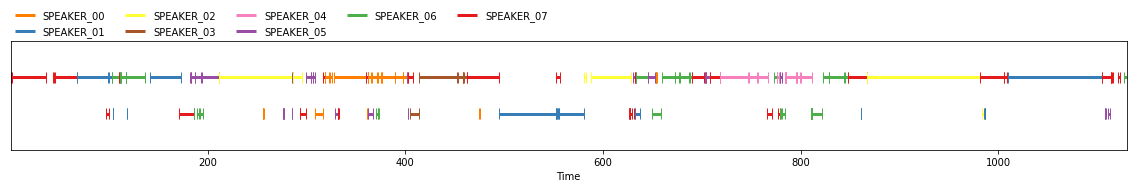

In [15]:
# %%memit 

# apply the pipeline to an audio file
hypothesis


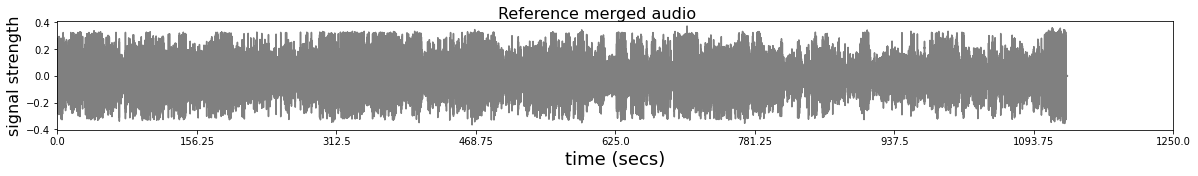

In [16]:
sr = 16000
signal, sr = librosa.load(single_audio, sr=sr) 

# plot and listen to the audio and visualize the tracks
fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Reference merged audio', fontsize=16)
plt.xlabel('time (secs)', fontsize=18)
ax.margins(x=0)
plt.ylabel('signal strength', fontsize=16);
a,_ = plt.xticks();plt.xticks(a,a/sr);
plt.show()


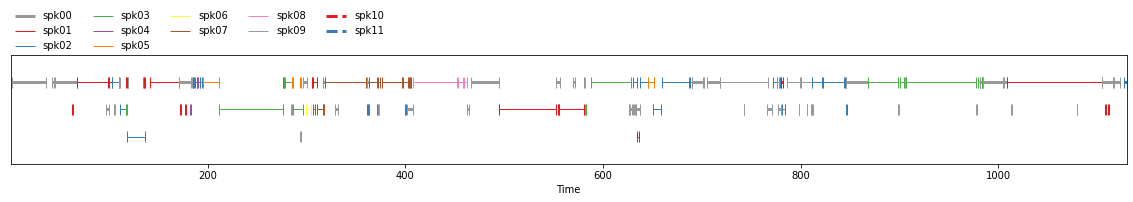

In [17]:
# visualize groundtruth
groundtruth
# This nice visualization is by pyannote.core and basically indicates when each speaker speaks.
# SPEAKER {file_name} 1 {start_time} {duration} <NA> <NA> {speaker_name} <NA> <NA>

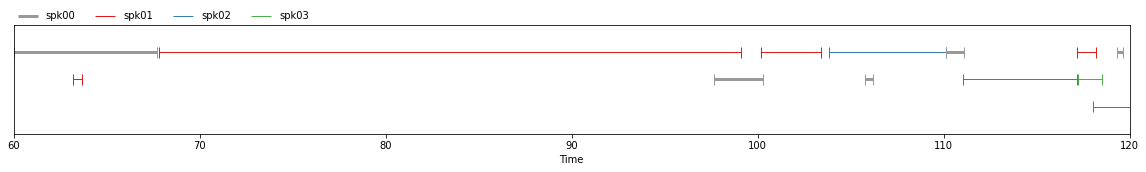

In [18]:
from pyannote.core import Segment, notebook
# make notebook visualization zoom on 60s < t < 120s time range
EXCERPT = Segment(60, 120)
notebook.crop = EXCERPT

# visualize excerpt from groundtruth
groundtruth

diarization error rate 2 = 11.6%


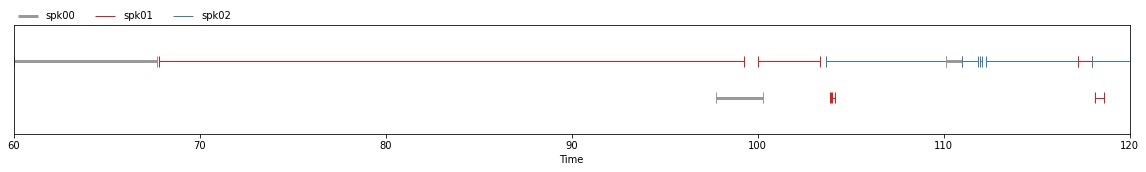

In [19]:
# DER by finding optimal one-to-one mapping between groundtruth and hypothesized speakers.
from pyannote.metrics.diarization import DiarizationErrorRate

metric = DiarizationErrorRate()
der = metric(groundtruth, hypothesis)
print(f'diarization error rate 2 = {100 * der:.1f}%')


mapping = metric.optimal_mapping(groundtruth, hypothesis)
hypothesis = hypothesis.rename_labels(mapping=mapping)
hypothesis

In [20]:
# Overlap detection in audio
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained("pyannote/overlapped-speech-detection")
output = pipeline(single_audio).get_timeline()


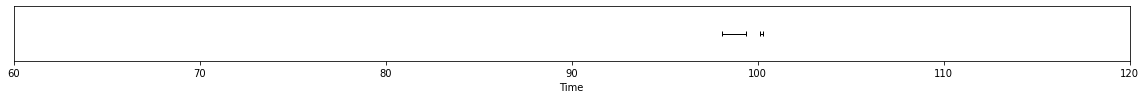

In [21]:
output

## visualisation of speakers second by second

In [22]:
import math
import time

def secondwise_speaker_iter(annotation):
    total_time = 0   
    timelines = annotation.get_timeline()

    speaker_dict = {}
    # print the result
    for turn, _, speaker in annotation.itertracks(yield_label=True):
#         print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")
        total_time = max(total_time, math.ceil(turn.end))
        
        for t in range(math.ceil(turn.start), math.ceil(turn.end)):
            if t not in speaker_dict.keys():
                speaker_dict[t] = [speaker]
            else:
                speaker_dict[t].append(speaker)
    return speaker_dict, total_time

def print_secondwise_speaker(annotation, time_step=1):
    print("Starting with delay of 1 s (Click on Audio above)...")
    print()
    
    time.sleep(time_step)
    
    speaker_dict, total_time = secondwise_speaker_iter(annotation)
    elapsed = 0
    print_list = []
    while(elapsed < total_time):
        time.sleep(time_step)
        elapsed += time_step
        if elapsed in speaker_dict.keys():
            print_list.append(speaker_dict[elapsed])
            print(f"\rAt: {elapsed:03d}s Speaker: {print_list[-1]}\t\t\t\t\t\t\t\t\t\t\t", end="")


In [ ]:
from IPython.display import Audio

# load audio waveform
Audio(single_audio, rate=16000)

In [ ]:
print_secondwise_speaker(diarization)

## visualise speaker embeddings

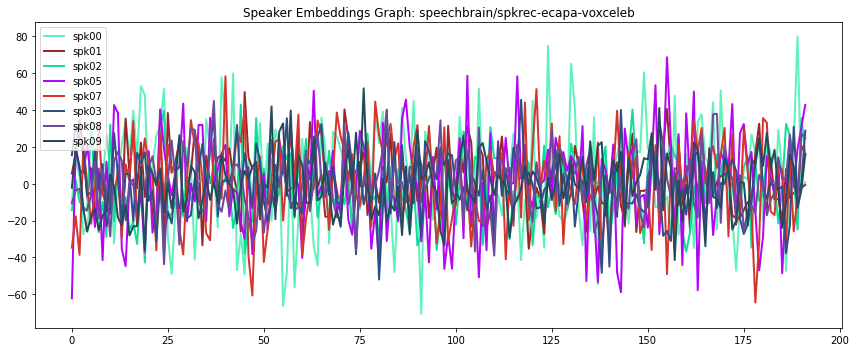

Saved embedding files to /home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out/zzyyo_embeddings.pkl


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from pyannote.audio import Inference
from pyannote.core import Segment
inference = Inference("pyannote/embedding", window="whole", device="cuda")

import torch
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
from pyannote.audio import Audio
from pyannote.core import Segment
audio = Audio(sample_rate=16000, mono=True)
import pickle as pkl

def get_speakers_embedding(annotation, audio_file, plot=True, embed_model="speechbrain/spkrec-ecapa-voxceleb"):
    """
    get single segments for each speaker, and return their embeddings
    `embedding` is (1 x D) numpy array extracted from the file excerpt.
    
    embed_model = ["speechbrain/spkrec-ecapa-voxceleb", "pyannote/embedding"]

    """
    model = PretrainedSpeakerEmbedding(
        embed_model,
        device=torch.device("cuda")
    )
    
    speaker_segments = {}
    speaker_embeds = {}

    for turn, _, speaker in annotation.itertracks(yield_label=True):
        # print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker={speaker}")
        if not speaker in speaker_segments.keys():
            speaker_segments[speaker] = (turn.start, turn.end)

    
    for speaker, turn in speaker_segments.items():
        # extract embedding for a speaker speaking between turns
        excerpt = Segment(turn[0], turn[1])
        excerpt_waveform, excerpt_sr = audio.crop(audio_file, excerpt)
        embed = model(excerpt_waveform[None])
        speaker_embeds[speaker] = embed[0] #TODO: explore it to be 2d by running on complete audio
        
        
    # Speaker spk00 embed shape:(192,)
    # print("ss",speaker_segments)
    # print("se", speaker_embeds)
    if plot == True:
        plt.rcParams["figure.figsize"] = [12, 5]
        plt.rcParams["figure.autolayout"] = True
        plt.rcParams['lines.linewidth'] = 2
        
        np.random.seed(42)
        x = np.arange(0,len(speaker_embeds[speaker]))
        plt.title(f"Speaker Embeddings Graph: {embed_model}")

        
        for speaker, embed in speaker_embeds.items():
            plt.plot(x, embed, color=np.random.rand(3,))
        plt.legend(speaker_embeds.keys())
        plt.show()
            
    # save embeddings
    audio_file_name = audio_file.split("/")[-1]
    name = os.path.join('/home/DATA/amit_kesari/SD1/pyannote-v2/data/voxconverse/out', audio_file_name[:-4])
    embeddings_file = name + '_embeddings.pkl'
    pkl.dump(speaker_embeds, open(embeddings_file, 'wb'))
    print("Saved embedding files to {}".format(embeddings_file))
    
    return speaker_embeds   


        
speaker_embeds = get_speakers_embedding(annotation = hypothesis, audio_file=single_audio, plot=True)



In [37]:

# compare embeddings using "cosine" distance
from scipy.spatial.distance import cdist
spk=list(speaker_embeds.keys())
print("Speakers:",spk)
distance = cdist([speaker_embeds[spk[0]]], [speaker_embeds[spk[1]]], metric="cosine")
distance

Speakers: ['spk00', 'spk01', 'spk02', 'spk05', 'spk07', 'spk03', 'spk08', 'spk09']


array([[1.01887474]])